
✅ After SMOTE class distribution:
Accident_severity
2    10415
1    10415
0    10415
Name: count, dtype: int64

📦 Data ready: 24996 training samples, 6249 test samples

📊 Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score
2        Random Forest  0.889582   0.889655  0.889582  0.888953
1        Decision Tree  0.831653   0.833469  0.831653  0.828398
0  Logistic Regression  0.732277   0.725642  0.732277  0.726833


<Figure size 1000x600 with 0 Axes>

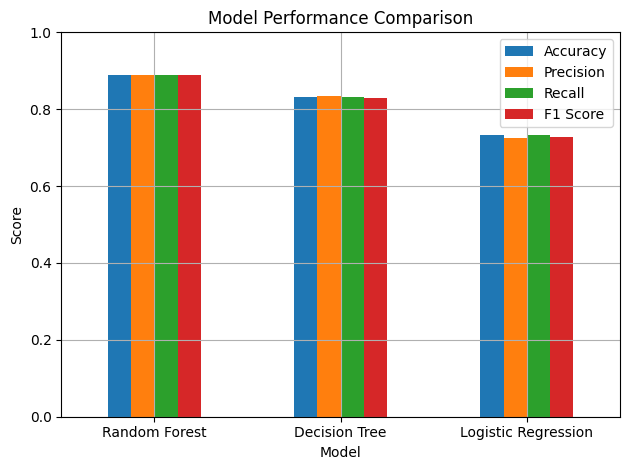


🏆 Best Performing Model: Random Forest
✅ Model and features saved to ../models/


In [1]:
# Week 4 & 5 - Training, Evaluation and Balancing with SMOTE

# --- Step 0: Import Libraries ---
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from imblearn.over_sampling import SMOTE

# --- Step 1: Load Dataset ---
df = pd.read_csv('../data/cleaned.csv')

# Categorical columns to encode
categorical_cols = [
    'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Driving_experience', 'Lanes_or_Medians', 'Types_of_Junction',
    'Road_surface_type', 'Light_conditions', 'Weather_conditions',
    'Type_of_collision', 'Vehicle_movement', 'Pedestrian_movement',
    'Cause_of_accident', 'Vehicle_driver_relation'
]

# --- Step 2: One-hot Encoding ---
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 3: Split features and labels
X = df_encoded.drop(columns=['Accident_severity'])
y = df_encoded['Accident_severity']

# ✅ Convert boolean columns to integers
X = X.astype(int)

# Step 4: Apply SMOTE Oversampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("\n✅ After SMOTE class distribution:")
print(pd.Series(y_balanced).value_counts())

# --- Step 5: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"\n📦 Data ready: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")

# --- Step 6: Train Models ---
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# --- Step 7: Evaluation ---
def get_metrics(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted')
    }

# Collect results
results = [
    get_metrics('Logistic Regression', y_test, lr_preds),
    get_metrics('Decision Tree', y_test, dt_preds),
    get_metrics('Random Forest', y_test, rf_preds)
]

results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print("\n📊 Model Performance Summary:")
print(results_df)

# --- Step 8: Visualize Results ---
plt.figure(figsize=(10, 6))
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Step 9: Save Best Model and Features ---
model_dir = os.path.join(os.pardir, 'models')
os.makedirs(model_dir, exist_ok=True)

joblib.dump(rf_model, os.path.join(model_dir, 'random_forest_model.pkl'))
joblib.dump(X.columns.tolist(), os.path.join(model_dir, 'feature_columns.pkl'))

print("\n🏆 Best Performing Model:", results_df.iloc[0]['Model'])
print("✅ Model and features saved to ../models/")